You've learned that regression tasks are those where you need an algorithm that ultimately outputs continuous numerical values. There are several ways to produce this kind of output, but the simplest and most commonly used method is linear regression. In this lesson, you'll explore how to formulate a linear regression model and estimate it using the ordinary least squares (OLS) method.

Although it isn't the only approach, OLS is by far the most common method of estimating linear regression models. This technique is so common and canonical that people often refer to it simply as *regression*, even though there are plenty of other techniques and types of models that qualify as regressions. Here, you'll cover the basic formulation of linear regression models and the OLS algorithm.

Specifically, you'll learn about the following topics in this lesson:

* General formulation of linear regression models
* Ordinary least squares
* How to find optimal coefficients for a linear regression model
* How to implement a linear regression model in scikit-learn



## Formulating a linear regression model

In the previous lesson, you saw that linear regression models plot a line of best fit representing the relationship between the features and the target. To be more precise, a linear regression model can be formulated mathematically like this:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon \qquad(eq.1)$$

In equation 1 (labeled eq.1 above), $y$ represents the target variable, $x_1, x_2,..., x_n$ represent the features, and $n$ denotes the number of features. The unknowns of this equation are the $\beta$ terms. $ \beta_0 $ refers to the *intercept* (also known as the *bias* or *constant*). All the other $\beta$ terms ($\beta_1, \beta_2,...,\beta_n$) are called the *coefficients*. The $\epsilon$ is the *error term* (also known as the *residual*), which represents the information in $y$ that is unexplained by the features.

**A note on terminology:** In linear regression models, it's common to refer to features in a model as *explanatory variables* or *independent variables*. It's also common to refer to the target variable as the *explained variable* or *dependent variable*. Don't be surprised if you stumble upon these alternative terms in other places.

The expression above can be written in a more compact form using the summation ( $\sum$ ) operator as follows:

$$ y = \beta_0 + \sum_{i=1}^{n}\beta_ix_i + \epsilon \qquad(eq.2)$$


In equation 2, $\sum_{i=1}^{n}$ adds up each $\beta_ix_i$ where the subscript $i$ refers to the index of the features and the coefficients. Hence, $\sum_{i=1}^{n}$ starts from $i=1$ and goes until $i=n$.


## Insurance charges dataset

Throughout this module, you'll explore linear regression modeling on a medical cost dataset originally from Kaggle. The original dataset is called *Medical Cost Personal Dataset* and can be found [on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). You'll be working with a SQL-based version of this dataset hosted on a PostgreSQL server. But if you want full documentation on the data, refer to the Kaggle link.

The data is about the costs charged by the insurance companies to individuals. These are costs that the insured individuals were required to pay after the insurance company made payments to medical providers. The dataset includes six variables as described below:

* `age`: The age of the individual. It's a numeric variable.
* `sex`: The biological sex of the insured. It is categorical, with two values: `male` and `female`.
* `bmi`: Body mass index. This index indicates whether an individual's weight is relatively high or low, based on height. This index defines an ideal range between `18.5` and `24.9`. The variable is continuous.
* `children`: How many dependent children the insured person has. Dependents are covered by the insurance plan. This is a numeric variable.
* `smoker`: This categorical variable indicates whether or not the person smokes. It has two values: `yes` and `no`.
* `region`: The person's residential area in the US. It's a categorical variable with four values: `northeast`, `southeast`, `southwest`, and `northwest`.
* `charges`: The medical costs (in US dollars) billed by the insurance company. It's a continuous variable.

In the examples, the target variable will be the charges billed by the insurance company. Because it's a continuous variable, you're dealing with a regression task.


## Preliminary data exploration

To choose the features that you'll use in your first model, do a brief exploratory analysis here. First, import the relevant libraries:

In [6]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

Next, load the data from the PostgreSQL database and print out some observations:

In [7]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
# insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)
with engine.begin() as conn:
    query = text("""SELECT * FROM medicalcosts""")
    insurance_df = pd.read_sql_query(query, conn)

# No need for an open connection, because you're only doing a single query
engine.dispose()


insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


Now, look at the distribution of your target variable: `charges`. Investigating how your target is distributed will help you understand the relationship between the target and the features. It's also useful for discovering some potential problems with your model, as you'll explore in the next lesson.

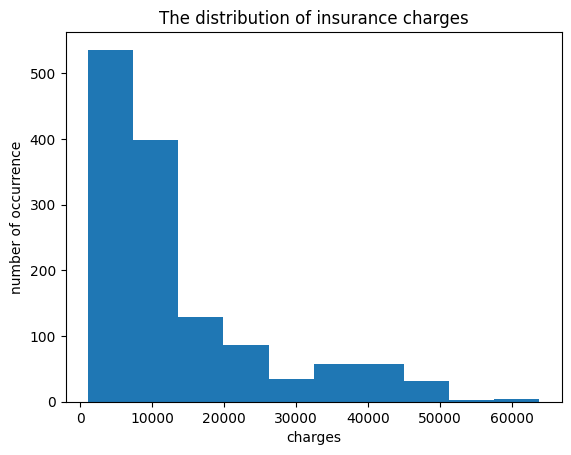

In [8]:
plt.hist(insurance_df.charges)
plt.title("The distribution of insurance charges")
plt.xlabel("charges")
plt.ylabel("number of occurrence")
plt.show()

Observe that `charges` is not normally distributed. Instead, it's highly skewed. *Skewness* is a measure of how asymmetric your data is with respect to the normal distribution. As you can see in the graph, the `charges` variable is not symmetric but skewed to the right. The majority of the observations have low `charges` values; few of the observations have high `charges` values. As a result, the distribution of `charges` is clustered at the leftmost part of the histogram.

Notice that the categorical variables are strings and you need to convert them to numerical values. This can be viewed as part of the feature-engineering process. One of the most convenient ways of converting categorical variables into numerical ones is called *one hot encoding*. In one hot encoding, you create a separate binary variable that takes `0` or `1` for each of the unique values of the categorical variable. The `get_dummies()` function from pandas does this job for you.

Below, call the `get_dummies()` function for the `sex` and `smoker` categorical variables in your dataset. Since both the `sex` and `smoker` variables include two values, the `get_dummies()` function will create two dummy (indicator) variables for you. Because one of them is enough to indicate whether the person is male or not and if they're a smoker or not, you keep only one of the newly created dummies both for `sex` and `smoker` in your DataFrame. Do this by feeding the parameter `drop_first`, which is set to `True`, into the `get_dummies()` function.

In [9]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

Look at a multilevel categorical variable being converted to dummies. In this data, you have `region`, which is a good example.

In [10]:
# Look at the values in the categorical feature
insurance_df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

You can see that there are four levels for `region`. Now, apply the `get_dummies` function and look at the results with the `head()` function.

In [11]:
regions_df = pd.get_dummies(insurance_df['region'])
regions_df.head()

,northeast,northwest,southeast,southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


Now you can see that you have a `0` and `1` indicator column for each of the four regions. Given that they originated from a single column, you know that they are exclusive. Therefore, if one is removed, then that column becomes the base region. This assumes that all rows in the dataset have a given region.
If you would like to add these columns to your working data going forward, you need to remove the original `regions` column and merge the `regions_df` DataFrame with your original DataFrame. Below is an example:


In [13]:
new_df = insurance_df.drop(['region'], axis =1).merge(regions_df,left_index=True, right_index=True)
new_df.head()

,age,sex,bmi,children,smoker,charges,is_male,is_smoker,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,16884.90,0,1,0,0,0,1
1,18,male,33.770,1,no,1725.55,1,0,0,0,1,0
2,28,male,33.000,3,no,4449.46,1,0,0,0,1,0
3,33,male,22.705,0,no,21984.50,1,0,0,1,0,0
4,32,male,28.880,0,no,3866.86,1,0,0,1,0,0


Now you know how to handle multiclass categorical data for inclusion in a linear regression model. For the remainder of this Notebook, you won't need to deal with `region`, so just move on and return to your other features for review.

At first glance, gender and smoking may play an important role in the insurance charges. So, look at whether you see some differences between the average costs billed to different genders and to people who smoke:

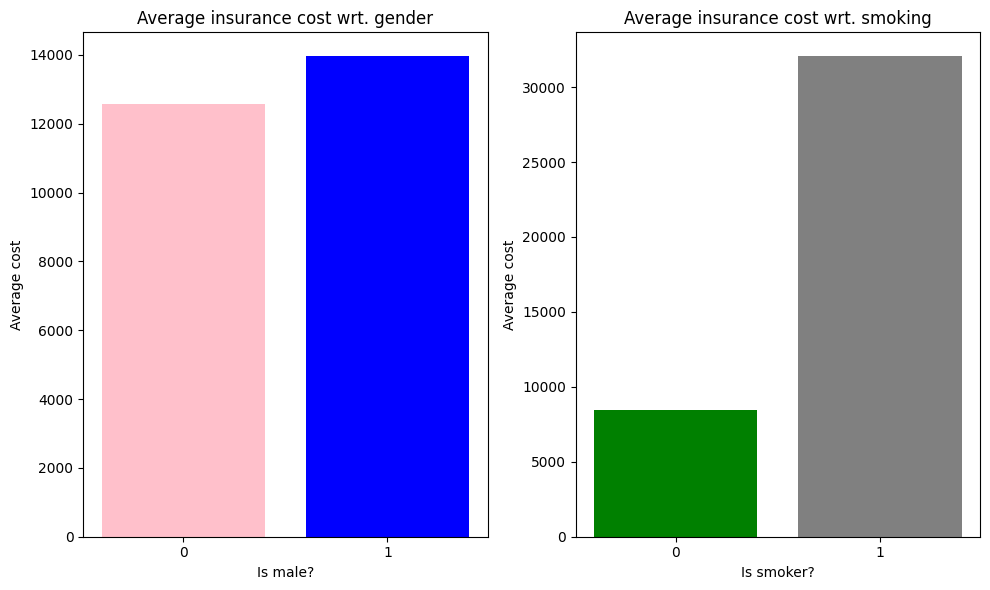

In [14]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(insurance_df.groupby("is_male")["charges"].mean().index, insurance_df.groupby("is_male")["charges"].mean(),
       color=("pink","blue"))
plt.title("Average insurance cost wrt. gender")
plt.ylabel("Average cost")
plt.xlabel("Is male?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(insurance_df.groupby("is_smoker")["charges"].mean().index, insurance_df.groupby("is_smoker")["charges"].mean(),
       color=("green","grey"))
plt.title("Average insurance cost wrt. smoking")
plt.ylabel("Average cost")
plt.xlabel("Is smoker?")
plt.xticks([0,1])

plt.tight_layout()
plt.show()


As can be seen in the graph, the average costs seem to be different between each group. That is to say, on average, males seem to be charged more than females, and smokers are charged more than nonsmokers.

Now, build your first model using these two features.

## Modeling the insurance charges with linear regression

Now, explore how you can model the insurance cost using a simple linear regression model. Your target variable is `charges`, and you'll include two categorical variables as your features: `is_male` and `is_smoker`. Hence, your model becomes the following:

$$ charges = \beta_0 + \beta_1is\_smoker + \beta_2is\_male + \epsilon \qquad(eq.3)$$

$\beta_0$ is the constant, and $\beta_1$ and $\beta_2$ are the coefficients of the `is_smoker` and `is_male` dummies, respectively.

**An important remark on the bias term:** Putting a constant in a model is optional, but it's a good idea to include a constant in every model that you build. Even though you believe that the constant would be zero, letting OLS decide whether it is zero or not is the safest way.

## How to find the optimal values for coefficients

Formulating a model is the first step in a regression problem. But, you need to find a way to discover the optimal values for the unknowns (the coefficients) in the equation above. Recall that the process of finding the optimal values of the unknowns is called *optimization*. Here, you need an optimization algorithm to solve for the optimal coefficient values.

The most common optimization algorithm used in the linear regression models is called *ordinary least squares* or *OLS*.


## The machinery of OLS

OLS tries to minimize the squared sums of the error terms ($\epsilon$) in the model. You can write the error term as follows:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i ) = \epsilon \qquad(eq.4)$$

If you take the square of each side, it becomes the following:

$$(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i )^2 = \epsilon^2 \qquad(eq.5)$$

Notice that this error term is for a single observation. If you have, say, $m$ observations in your dataset, then the sum of the squared errors can be represented like this:

$$\sum_{j=1}^{m}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_ix_{ij} )^2 = \sum_{j=1}^{m}\epsilon_j^2 \qquad(eq.6)$$

Recall that $i$ was representing the index of the features in the model. In the equation above, $j$ represents the index of the observations. Hence, you go over each observation and add up their squared error terms. However, using matrix notation simplifies the expression:

$$(Y - \beta X)^2 = \mathcal{E}^2 \qquad(eq.7)$$

You will not go deeper into the derivation of the coefficients here, but all that you need to do is take the derivative of both sides with respect to each coefficient and equate them to zero. If you solve the resulting equations, then you end up with the optimal values of the coefficients:

$$ \hat{\beta} = (X^TX)^{-1}X^TY \qquad(eq.8)$$

In equation 8, $\hat{\beta}$ indicates the estimated coefficients vector, $X^T$ refers to the transpose of the feature matrix ($X$), and superscript $^{-1}$ refers to the inverse of a matrix.

That's it! If you want to learn more about the derivation steps, you can read the [Wikipedia article](https://en.wikipedia.org/wiki/Ordinary_least_squares).

## An initial model for insurance charges

Using equation 3, above, build a simple linear regression model and estimate it using OLS. So far in this program, you've mainly used scikit-learn as your machine-learning package. Here, you'll be introduced to another popular library for regression analysis: statsmodels. You may find it easier to use statsmodels for fitting linear regression models, because its `summary()` function outputs many important metrics in a tabular form. Getting the same metrics in scikit-learn requires more work.

But first, look at how to fit linear regression models in scikit-learn. You'll use the `LinearRegression()` model from the `linear_model` module:

In [15]:
# `Y` is the target variable
Y = insurance_df['charges']
# `X` is the feature set which includes the
# `is_male` and `is_smoker` variables
X = insurance_df[['is_male','is_smoker']]

# Create a `LinearRegression` model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# Fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.035592512448


The `fit()` method from `LinearRegression` runs the OLS algorithm by default. Because you get the parameters using OLS, you can write your estimated model:

$$ charges = 8466.04 + -65.38is\_male + 23622.14is\_smoker \qquad(eq.9)$$

According to the estimation results, the constant term is `8466.04`. The estimated coefficients of the `is_male` and `is_smoker` features are `-65.38` and `23622.14`, respectively. Later in this module, you'll learn how to interpret these estimated coefficients.

Now, run the same model, using statsmodels this time. If you haven't installed it already, you can run `pip install statsmodels` from the command line.

In [16]:
import statsmodels.api as sm

# You need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1088.
Date:                Sat, 04 Nov 2023   Prob (F-statistic):          4.78e-281
Time:                        19:08:44   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1335   BIC:                         2.768e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8466.0356    303.541     27.891      0.000    7870.566    9061.506
is_male      -65.3787    409.809     -0.160      0.873    -869.318     738.561
is_smoker   2.362e+04    507.736     46.524      0.000    2.26e+04    2.46e+04
==============================================================================
Omnibus:                      135.842   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.897
Skew:                           0.727   Prob(JB):                     9.71e-47
Kurtosis:                       4.299   Cond. No.                         2.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First, notice that you added a constant to your existing feature set using this code: `X = sm.add_constant(X)`. This is because statsmodels' `fit()` function doesn't add a constant by default, unlike scikit-learn's `fit()` function.

Second, when you call the `summary()` function on the fitted OLS model, it prints out a table of statistics. For example, in the upper side of the table, you can see statistics like R-squared, adjusted R-squared, F-statistic, Log-likelihood, AIC, and BIC. Those are related to the goodness of fit of your model. In the lower part, you can see statistics like Durbin-Watson, Jarque-Bera, skewness, and kurtosis. Those statistics are related to whether your model satisfies some assumptions of the linear regression model. For example, *skewness* is a measure of how asymmetric your data is, and *kurtosis* is a measure of whether your data is heavy tailed or light tailed with respect to a normal distribution. Don't worry about the details of these statistics; you'll go over some of them later in this module. For now, notice that in the middle of the table, estimated values for the coefficients are given. And those estimated values are exactly the same as what you got from the scikit-learn.